# Refine Feature Groups into Final Bins

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import jax
import jax.numpy as jnp

In [3]:
from zotbin.group import load_groups
from zotbin.reweight import reweighted_metrics
from zotbin.binned import load_binned

In [4]:
zedges, fedges, grpidw, zhistw, zsimw = load_groups('groups_20_120_200.npz')

In [5]:
zedges, fedges, grpidn, zhistn, zsimn = load_groups('groups_20_120_200_nowgt.npz')

In [6]:
init_data = load_binned('binned_40.npz')

In [7]:
assert (len(zedges) - 1) % (len(init_data[0]) - 1) == 0
downsampling = (len(zedges) - 1) // (len(init_data[0]) - 1)
print(f'Downsampling by {downsampling}')

Downsampling by 3


In [9]:
def get_score(group_weights, zhist, gals_per_arcmin2=20., fsky=0.25, metric='FOM_DETF_3x2'):
    # Calculate the redshift distribution in each output bin.
    ngrp, nzbin = zhist.shape
    nbin = len(group_weights)
    assert group_weights.shape[1] == ngrp
    zhist_out = group_weights.dot(zhist)
    # Downsample to the redshift binning used for fast reweighted scores.
    zhist_ds =  zhist_out.reshape(nbin, nzbin // downsampling,  downsampling).sum(axis=-1)
    # Calculate the corresponding weights to use.
    w = zhist_ds / zhist.sum()
    # Calculate the metrics for these weights.
    weights = jnp.array([w,  w])
    scores = reweighted_metrics(weights, *init_data[1:], gals_per_arcmin2=gals_per_arcmin2, fsky=fsky, metrics=[metric])
    return scores[metric]

## Method 1

Keep the groups in their mean-redshift sorted order and find the breakpoints with the maximum score using an exhaustive search:

In [13]:
def method1_weights(*breaks, zhist=None):

    ngrp, nzbin = zhist.shape
    nbin = len(breaks) + 1
    w = np.zeros((nbin, ngrp))
    breaks = np.concatenate(([0], breaks, [ngrp]))
    assert np.all(np.diff(breaks) > 0)
    igrp = np.arange(ngrp)
    for i in range(nbin):
        sel = (breaks[i] <= igrp) & (igrp < breaks[i + 1])
        w[i, sel] = 1.
    return w

In [50]:
def iter_breaks(ngrp, nbin):
    assert nbin >= 2 and nbin <= 5
    for i1 in range(1, ngrp - nbin):
        if nbin == 2:
            yield [i1]
            continue
        for i2 in range(i1 + 1, ngrp - nbin + 1):
            if nbin == 3:
                yield [i1, i2]
                continue
            for i3 in range(i2 + 1, ngrp - nbin + 2):
                if nbin == 4:
                    yield [i1, i2, i3]
                    continue
                for i4 in range(i3 + 1, ngrp - nbin + 3):
                    yield [i1, i2, i3, i4]

In [51]:
def method1_optimize(nbin=2, zhist=None):
    scores = []
    breaks = []
    ngrp, nzbin = zhist.shape
    for brk in iter_breaks(ngrp, nbin):
        breaks.append(brk)
        w = method1_weights(*brk, zhist=zhist)
        scores.append(float(get_score(w, zhist=zhist)))
    plt.plot(scores)
    plt.show()
    ibest = np.argmax(scores)
    print(f'Best breaks are {breaks[ibest]} with score = {scores[ibest]}.')
    wbest =  method1_weights(*breaks[ibest], zhist=zhist)
    zc = 0.5 * (zedges[1:] + zedges[:-1])
    dndz =  wbest.dot(zhist)
    for i in range(nbin):
        plt.plot(zc, dndz[i])
    plt.xlabel('Redshift $z$')
    plt.yticks([])
    plt.xlim(zedges[0], zedges[-1])
    plt.ylim(0, None)

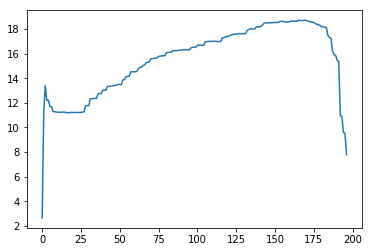

Best breaks are [171] with score = 18.72217559814453.
CPU times: user 18.4 s, sys: 695 ms, total: 19.1 s
Wall time: 17.9 s


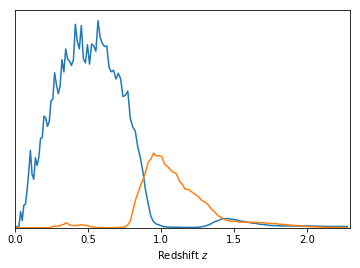

In [52]:
%time method1_optimize(nbin=2, zhist=zhistw)

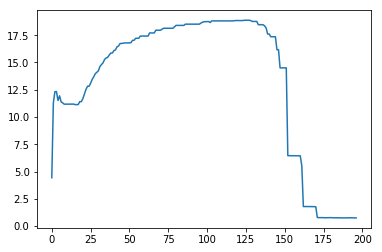

Best breaks are [128] with score = 18.873262405395508.
CPU times: user 18.4 s, sys: 563 ms, total: 18.9 s
Wall time: 17.8 s


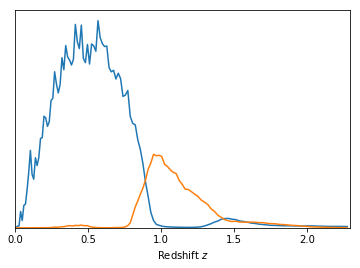

In [53]:
%time method1_optimize(nbin=2, zhist=zhistn)

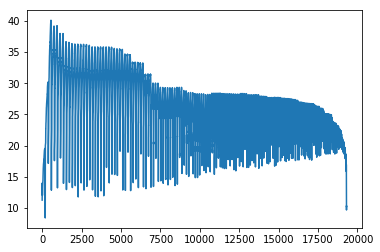

Best breaks are [3, 171] with score = 40.1136589050293.
CPU times: user 37min 16s, sys: 58 s, total: 38min 14s
Wall time: 36min 5s


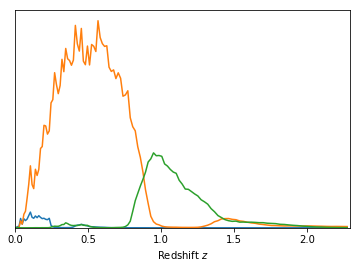

In [54]:
%time method1_optimize(nbin=3, zhist=zhistw)

## Method 2

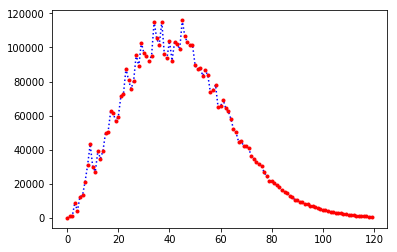

In [8]:
plt.plot(zhistw.sum(axis=0), 'b:');
plt.plot(zhistn.sum(axis=0), 'r.');

In [23]:
def optimize_weights(nbin=2, niter=100, eta=0.5, zhist=zhistw, random_init=1, gals_per_arcmin2=20., fsky=0.25, metric='FOM_DETF_3x2'):

    ngrp, nzbin = zhist.shape
    
    # Calculate the normalized n(z) for all galaxies.
    nds = nzbin // downsampling
    nofz = jnp.array(zhist.sum(axis=0).reshape(nds, downsampling).sum(axis=1))
    nofz /= nofz.sum()

    if random_init is None:
        # Initialize weights for equal bin contents.
        cdf = np.cumsum(nofz)
        cdf = np.concatenate(([0], cdf)) / cdf[-1]
        s = np.linspace(0, 1, nbin + 1)
        brk = np.interp(s, cdf, np.arange(nds + 1))
        w = np.zeros((nbin, nds))
        x = np.arange(nds)
        for i in range(nbin):
            sel = (x >= brk[i]) & (x < brk[i + 1])
            w[i, sel] = 5.
        p = jnp.array(w - w.sum(axis=0) / nbin)
    else:
        # Initialize random weights.
        gen = np.random.RandomState(seed=random_init)
        p = jnp.array(gen.normal(size=(nbin, nds)))
    
    @jax.jit
    def get_weights(p):
        w = jnp.exp(p)
        return w / w.sum(axis=0) * nofz
    
    @jax.jit
    def score(p):
        w = get_weights(p)
        weights = jnp.array([w,  w])
        return reweighted_metrics(
            weights, *init_data[1:], gals_per_arcmin2=gals_per_arcmin2, fsky=fsky, metrics=[metric])[metric]

    value_and_score = jax.jit(jax.value_and_grad(score))
    
    scores = []
    max_score = 0
    for it in range(niter):
        score, grads = value_and_score(p)
        scores.append(float(score))
        if scores[-1] > max_score:
            wbest = get_weights(p)
            max_score = scores[-1]
        p = p + eta * grads
        if it % 50 == 0:
            print(it, scores[-1])
    plt.plot(scores)
    plt.show()

    print(f'Max score: {max_score:.3f}.')
    w = np.asarray(wbest)
    ze = init_data[0]
    zc = 0.5 * (ze[1:] + ze[:-1])
    for i in range(nbin):
        plt.fill_between(zc, w[i], alpha=0.4)

    return w, max_score

0 3.2018086910247803
50 21.977750778198242


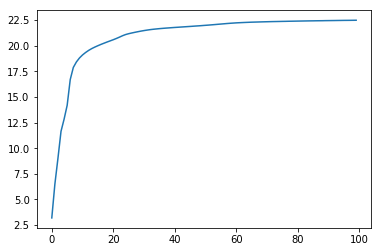

Max score: 22.472.
CPU times: user 3.55 s, sys: 135 ms, total: 3.69 s
Wall time: 3.58 s


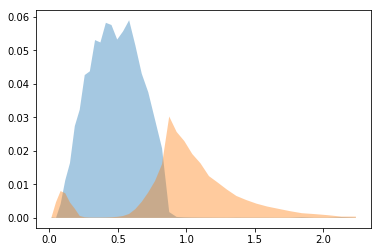

In [28]:
%time w2, m2 = optimize_weights(nbin=2, eta=1., niter=100)

0 6.0063157081604
50 45.33053207397461


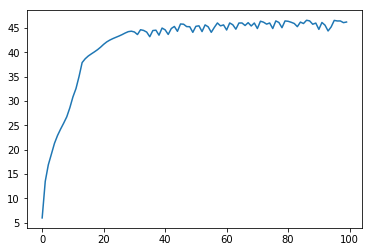

Max score: 46.574.
CPU times: user 7.89 s, sys: 71 ms, total: 7.97 s
Wall time: 7.84 s


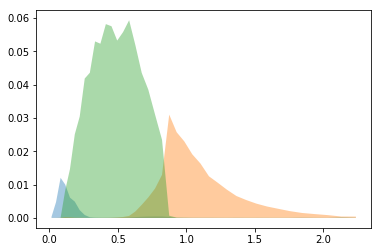

In [29]:
%time w3, m3 = optimize_weights(nbin=3, eta=1., niter=100)

0 8.490499496459961
50 58.03609085083008
100 62.18034744262695
150 62.82968521118164
200 63.00864028930664
250 63.640865325927734
300 65.184814453125
350 64.04039001464844
400 65.45266723632812
450 65.64655303955078


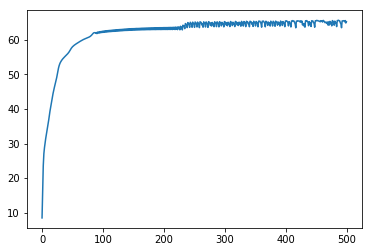

Max score: 65.698.
CPU times: user 1min 17s, sys: 149 ms, total: 1min 17s
Wall time: 1min 17s


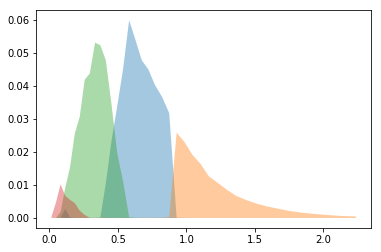

In [32]:
%time w4, m4 = optimize_weights(nbin=4, eta=0.5, niter=500)

0 9.764266967773438
50 62.84239959716797
100 70.74346923828125
150 73.1115493774414
200 72.82343292236328
250 74.05504608154297
300 73.94087982177734
350 74.84740447998047
400 75.19644165039062
450 75.52391052246094


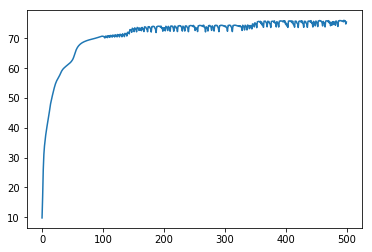

Max score: 76.101.
CPU times: user 2min 56s, sys: 518 ms, total: 2min 57s
Wall time: 2min 57s


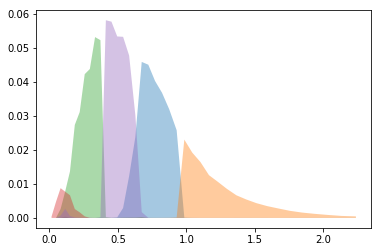

In [33]:
%time w5, m5 = optimize_weights(nbin=5, eta=0.5, niter=500)

0 13.888534545898438
50 68.62844848632812
100 75.19667053222656
150 76.26265716552734
200 77.2719497680664
250 78.62643432617188
300 77.6267318725586
350 79.51612091064453
400 79.62677764892578
450 77.9648208618164


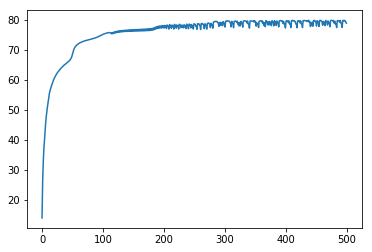

Max score: 79.900.
CPU times: user 5min 49s, sys: 970 ms, total: 5min 50s
Wall time: 5min 50s


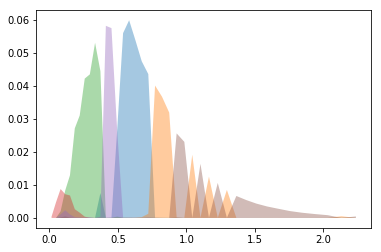

In [34]:
%time w6, m6 = optimize_weights(nbin=6, eta=0.5, niter=500)

0 54.26852035522461
50 75.6591567993164
100 78.65259552001953
150 79.76007080078125


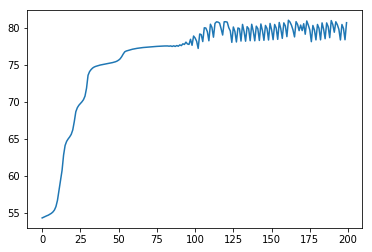

CPU times: user 2min 18s, sys: 616 ms, total: 2min 19s
Wall time: 2min 19s


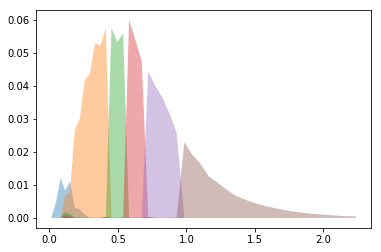

In [88]:
%time w6, m6 = method2_optimize(nbin=6, eta=0.7, niter=200)

0 16.436464309692383
50 84.64531707763672
100 86.92375183105469
150 88.50049591064453
200 88.01998138427734
250 88.68807983398438


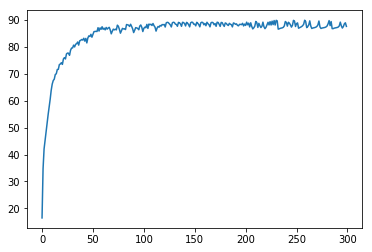

Max score: 89.942.
CPU times: user 6min 28s, sys: 1.22 s, total: 6min 29s
Wall time: 6min 29s


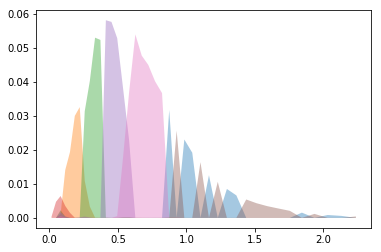

In [35]:
%time w7, m7 = optimize_weights(nbin=7, eta=1., niter=300)

0 22.10607147216797
50 89.36427307128906
100 96.18096923828125
150 99.5829086303711


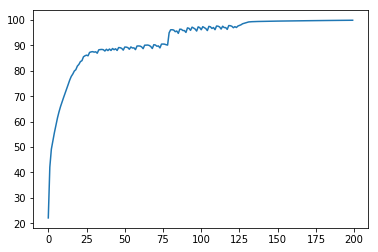

Max score: 99.917.
CPU times: user 6min 57s, sys: 866 ms, total: 6min 58s
Wall time: 6min 58s


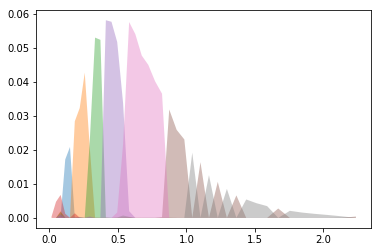

In [36]:
%time w8, m8 = optimize_weights(nbin=8, eta=1., niter=200)

0 24.794164657592773
50 94.96270751953125
100 96.4365005493164
150 96.34480285644531


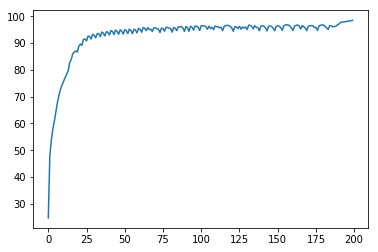

Max score: 98.481.
CPU times: user 10min 56s, sys: 1.28 s, total: 10min 57s
Wall time: 10min 57s


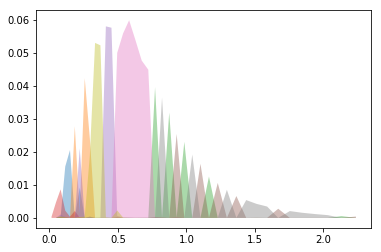

In [37]:
%time w9, m9 = optimize_weights(nbin=9, eta=1., niter=200)

0 80.83680725097656
50 99.19654846191406


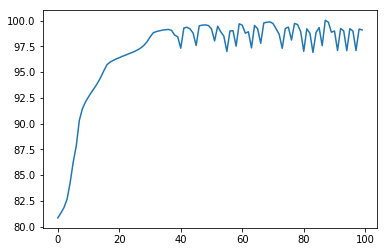

CPU times: user 5min 39s, sys: 843 ms, total: 5min 40s
Wall time: 5min 40s


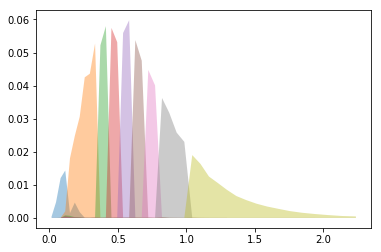

In [91]:
%time w9, m9 = method2_optimize(nbin=9, eta=0.7, niter=100)

0 86.00867462158203
50 106.37491607666016


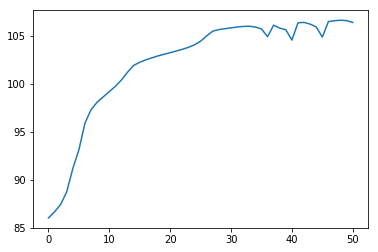

CPU times: user 4min 23s, sys: 720 ms, total: 4min 24s
Wall time: 4min 24s


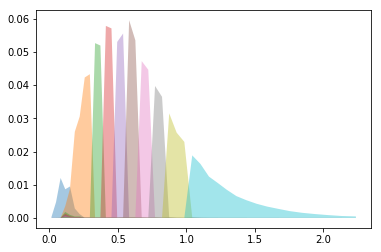

In [92]:
%time w10, m10 = method2_optimize(nbin=10, eta=0.7, niter=51)